In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import _tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 150)
from sklearn.tree import plot_tree



In [67]:
df = pd.read_csv("/Users/carolbarroco/Documents/RecomendSisKNN/TG2 RecommendSys/GitHub/T2-Indroducao-Ciencia-de-Dados/Data/MPBROCKMETAL_KGDataSet.csv")

In [63]:


X = df.iloc[:, 6:20]
y = df["track_genre"]
feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

label_mapping = {label: idx for idx, label in enumerate(clf.classes_)}
y_test_mapped = y_test.map(label_mapping)


y_pred = best_tree.predict(X_test)
y_pred

cm = confusion_matrix(y_test_mapped, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=labels,
            yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: 'Mr. Brightside'

In [32]:
print(classification_report(y_test_mapped,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       239
           1       0.95      0.94      0.94       262
           2       0.94      0.97      0.95       249

    accuracy                           0.95       750
   macro avg       0.95      0.95      0.95       750
weighted avg       0.95      0.95      0.95       750



In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import _tree
import pandas as pd
import numpy as np

# === 1. Prepare Data ===
X = df.iloc[:, 6:20]
y = df["track_genre"]
feature_names = X.columns

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=feature_names)

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_labels = label_encoder.classes_

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42
)

# === 2. Train Random Forest ===
clf = RandomForestClassifier(n_estimators=100, random_state=42, criterion="entropy")
clf.fit(X_train, y_train)

# === 3. Find Best Tree by Accuracy ===
best_accuracy = 0
best_tree_index = 0

for i, tree in enumerate(clf.estimators_):
    y_pred = tree.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_tree_index = i

print(f"Best tree index (accuracy): {best_tree_index}")
print(f"Best tree accuracy: {best_accuracy:.4f}")

best_tree = clf.estimators_[best_tree_index]

# === 4. Extract Rules from Best Tree ===
def extract_rules(tree, feature_names, X_data, index_data):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    rules = []
    
    def recurse(node, depth, data_indices):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            entropy = tree_.impurity[node]
            left = tree_.children_left[node]
            right = tree_.children_right[node]
            rules.append({
                "feature": name,
                "threshold": threshold,
                "": entropy,
                "depth": depth,
                "node": node,
                "data_indices": data_indices
            })
            left_indices = data_indices[X_data.loc[data_indices, name] <= threshold]
            right_indices = data_indices[X_data.loc[data_indices, name] > threshold]
            recurse(left, depth + 1, left_indices)
            recurse(right, depth + 1, right_indices)
    
    recurse(0, 0, index_data)
    return rules

rules = extract_rules(best_tree, feature_names=X.columns, X_data=X, index_data=X.index)
rules_df = pd.DataFrame(rules)

print("\nSample of extracted rules:")
print(rules_df.head())

# === 5. Evaluation: Forest vs Best Tree ===
forest_pred = clf.predict(X_test)
tree_pred = best_tree.predict(X_test)

forest_acc = accuracy_score(y_test, forest_pred)
tree_acc = accuracy_score(y_test, tree_pred)

forest_probs = clf.predict_proba(X_test)
tree_probs = best_tree.predict_proba(X_test)

forest_logloss = log_loss(y_test, forest_probs, labels=range(len(class_labels)))
tree_logloss = log_loss(y_test, tree_probs, labels=range(len(class_labels)))

print(f"\nRandom Forest accuracy: {forest_acc:.4f}")
print(f"Best Tree accuracy:     {tree_acc:.4f}")
print(f"Random Forest log loss: {forest_logloss:.4f}")
print(f"Best Tree log loss:     {tree_logloss:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/uti

Best tree index (accuracy): 98
Best tree accuracy: 0.9520

Sample of extracted rules:
        feature  threshold            depth  node  \
0    popularity   0.104167  1.584250      0     0   
1  acousticness   0.004169  0.511205      1     1   
2           key   0.136364  0.584728      2     2   
3   duration_ms   0.221093  1.000000      3     3   
4      loudness   0.736232  0.918296      4     5   

                                        data_indices  
0             RangeIndex(start=0, stop=3000, step=1)  
1  Index([  10,   11,   14,   17,   23,   27,   2...  
2  Index([1028, 1114, 1115, 1117, 1120, 1130, 115...  
3  Index([1156, 1217, 1227, 1228, 1230, 1241, 124...  
4  Index([1217, 1227, 1228, 1230, 1241, 1242, 124...  

Random Forest accuracy: 0.9733
Best Tree accuracy:     0.9520
Random Forest log loss: 0.1421
Best Tree log loss:     1.7301


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


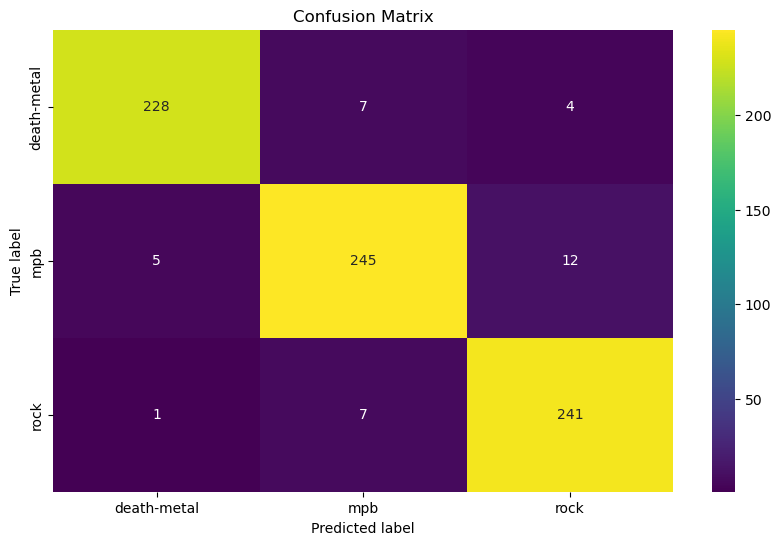

In [129]:
y_decoded = label_encoder.inverse_transform(y_encoded)

cm = confusion_matrix(y_test, tree_pred)
class_labels = label_encoder.classes_

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

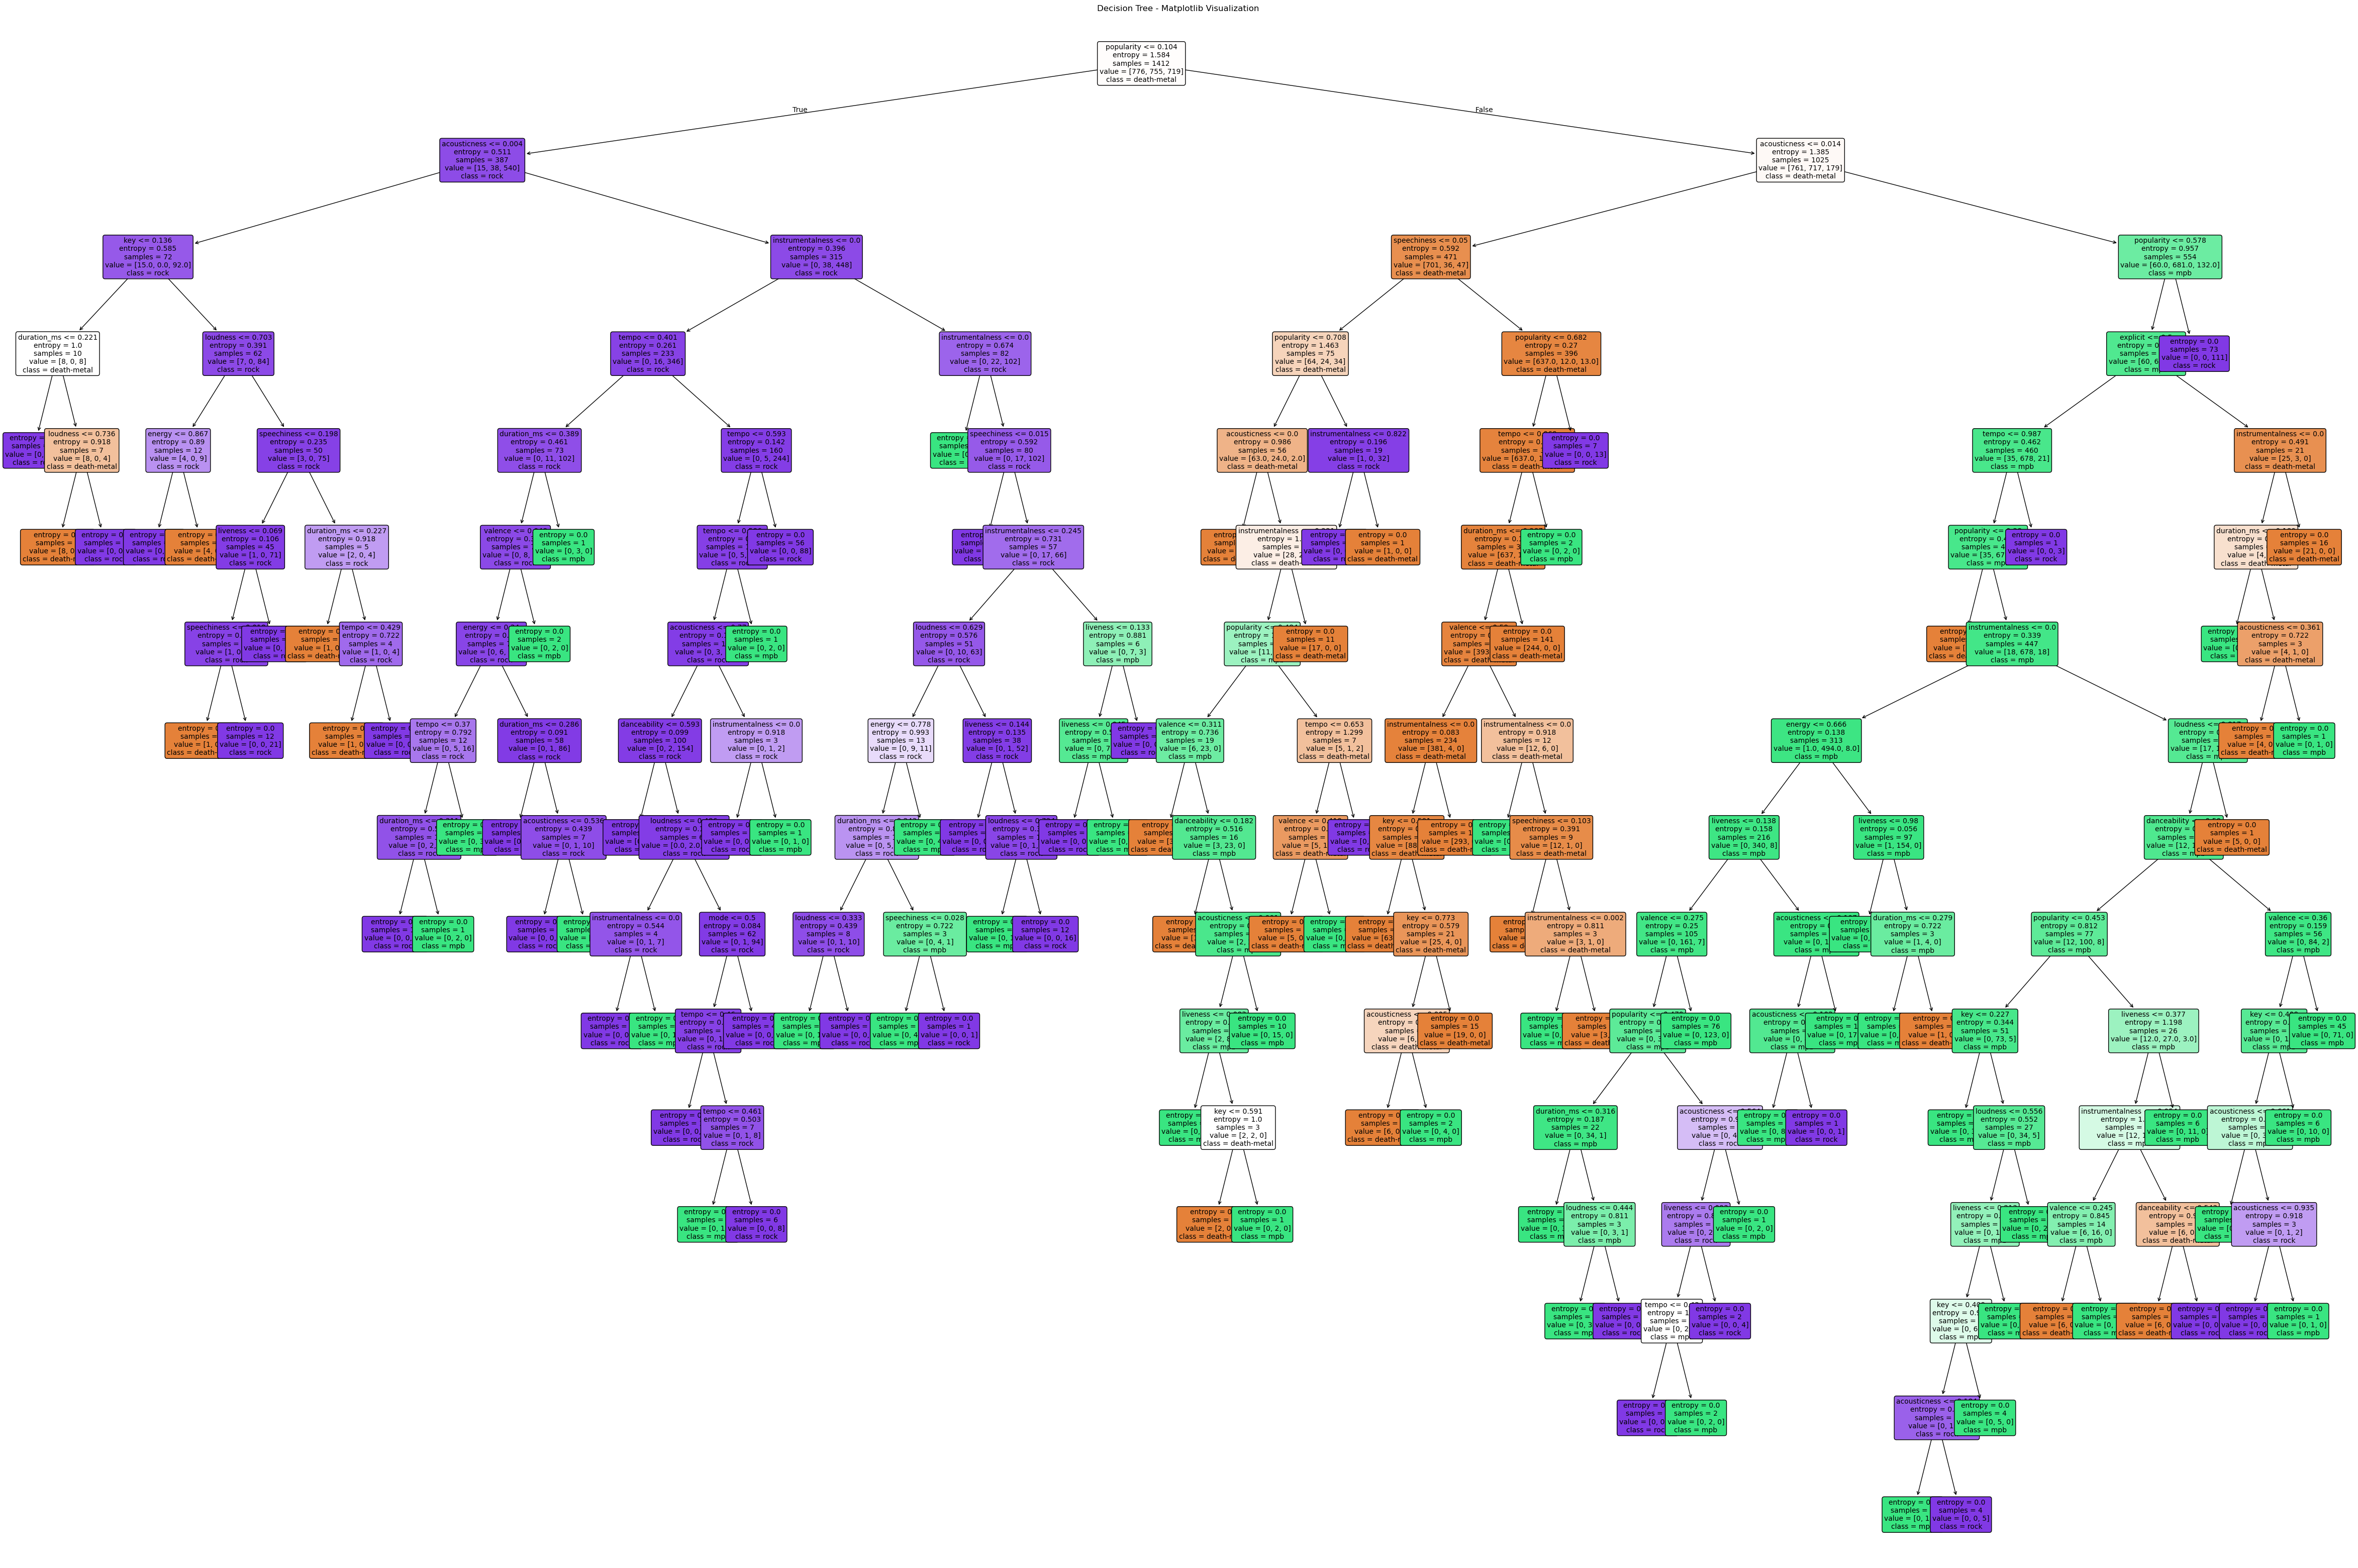

In [130]:
# # Invert the label mapping to get original labels by index
# inv_label_mapping = {v: k for k, v in y_encoded.items()}
# class_names = [inv_label_mapping[i] for i in range(len(inv_label_mapping))]


original_labels = label_encoder.inverse_transform(y_encoded)
class_names = label_encoder.classes_  # Returns array like: ['black metal' 'mpb' 'rock']


plt.figure(figsize=(60, 40))  
plot_tree(best_tree,
          feature_names=feature_names,
          class_names=class_names,  
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree - Matplotlib Visualization")
plt.show()


In [131]:
node_index_all = list(rules_df["node"])
node_index_leaf = list()

tree = best_tree.tree_  # ou qualquer outro DecisionTreeClassifier.tree_

def is_leaf(node_id):
    return tree.children_left[node_id] == _tree.TREE_LEAF and tree.children_right[node_id] == _tree.TREE_LEAF

for node_id in range(tree.node_count):
    if (is_leaf(node_id) == True):
        node_index_leaf.append(node_id)
        
        

len(node_index_leaf)

106

In [132]:
len(X_test)

750

In [133]:
# `best_tree` is your DecisionTreeClassifier instance
# `X_data` is the DataFrame you want to trace, e.g., X_test or X

# 1. Get the node index for each sample
node_indices = best_tree.apply(X_test)

# 2. Create a DataFrame to link sample indexes and node indexes
df_nodes = pd.DataFrame({
    'sample_index': X_test.index,
    'node_id': node_indices
})

# 3. Filter only leaf nodes (where children_left == children_right == -1)
tree_ = best_tree.tree_
leaf_nodes = [i for i in range(tree_.node_count) if tree_.children_left[i] == _tree.TREE_LEAF]

# 4. Filter df_nodes to only include samples that stopped at leaf nodes
df_leaf_samples = df_nodes[df_nodes['node_id'].isin(leaf_nodes)]

df_leaf_samples["node_id"].nunique()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


68

In [134]:


# `best_tree` is your DecisionTreeClassifier instance
# `X_data` is the DataFrame you want to trace, e.g., X_test or X

# 1. Get the node index for each sample
node_indices2 = best_tree.apply(X_train)


# Create the base DataFrame
df_nodes2 = pd.DataFrame({
    'sample_index': X_train.index,
    'node_id': node_indices2  # node_indices2 = best_tree.apply(X_train)
})

# Filter to keep only rows where the node_id is a leaf node
df_leaf_assignments = df_nodes2[df_nodes2['node_id'].isin(leaf_nodes)].copy()

# Reset index for neatness
df_leaf_assignments.reset_index(drop=True, inplace=True)

# Final DataFrame output
df_leaf_assignments


df_complete_leaf_assigments = pd.concat([df_leaf_assignments,df_leaf_samples], ignore_index=True )

df_complete_leaf_assigments = df_complete_leaf_assigments.sort_values("sample_index")
df_complete_leaf_assigments = df_complete_leaf_assigments.rename(columns={"sample_index":"index"})
df_leaf_assignments["node_id"].nunique()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


106

In [138]:


df= df.rename(columns={"Unnamed: 0.1": "index"})

df_with_subset_leaf_nodes = pd.merge(df_complete_leaf_assigments, df, on='index')
df_with_subset_leaf_nodes["node_id"].nunique()

df_with_subset_leaf_nodes.to_csv("AftDTsMPBROCKMETAL_validation.csv")



In [137]:
df = pd.read_csv("/Users/carolbarroco/Documents/RecomendSisKNN/TG2 RecommendSys/GitHub/T2-Indroducao-Ciencia-de-Dados/Data/MPBROCKMETAL_KGDataSet.csv")
df_complete_leaf_assigments["node_id"].value_counts()

node_id
125    391
133    290
165    227
163    216
158    173
210    167
60     134
34     129
55     103
200    100
44      76
119     69
17      68
90      49
77      45
64      40
111     37
124     37
147     35
173     32
103     29
109     26
182     24
16      22
80      22
51      21
209     21
135     20
30      19
140     18
161     17
191     16
187     15
199     14
7       14
36      13
180     13
10      12
54      11
129     11
122     11
106     11
71       9
189      9
181      8
11       6
94       6
22       6
84       6
179      6
186      5
167      5
132      5
85       4
73       4
4        4
57       4
108      4
21       4
38       4
207      4
6        4
127      4
99       4
101      4
123      4
195      4
156      3
19       3
107      3
47       3
74       3
201      3
162      3
79       3
197      3
149      3
205      3
168      3
62       2
157      2
37       2
39       2
83       2
131      2
75       2
59       2
154      2
134      2
155      2
10